In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3820455/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Lido"
SPLITS_FREQ = "W-WED"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-07-06"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 223 non-null    object        
 1   author             223 non-null    object        
 2   date               223 non-null    datetime64[us]
 3   start              223 non-null    datetime64[us]
 4   end                223 non-null    datetime64[us]
 5   platform_proposal  223 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 10.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56473 entries, 0 to 56472
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        56473 non-null  object        
 1   proposal  56473 non-null  object        
 2   voter     56473 non-null  object        
 3   date      56473 non-null  datetime64[us]
dtypes:

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Lido/baseline/folds-info_W-WED_normalize.parquet
fold
2023-04-26    48534
2023-05-03    49006
2023-05-10    51767
2023-05-17    52303
2023-05-24    52949
2023-05-31    54572
2023-06-07    54993
2023-06-14    55022
2023-06-21    55022
2023-06-28    56263
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W17,2,1469,792,734.50,1.85,443,258,221.50,1.72
2023-W18,0,0,0,nan,nan,0,0,nan,nan
2023-W19,4,2761,900,690.25,3.07,532,203,133.00,2.62
2023-W20,0,0,0,nan,nan,0,0,nan,nan
2023-W21,2,476,460,238.00,1.03,288,283,144.00,1.02
2023-W22,4,1440,561,360.00,2.57,411,190,102.75,2.16
2023-W23,1,113,113,113.00,1.00,24,24,24.00,1.00
2023-W24,0,0,0,nan,nan,0,0,nan,nan
2023-W25,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W17 & 2 & 1469 & 792 & 734.50 & 1.85 & 443 & 258 & 221.50 & 1.72 \\
2023-W18 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W19 & 4 & 2761 & 900 & 690.25 & 3.07 & 532 & 203 & 133.00 & 2.62 \\
2023-W20 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W21 & 2 & 476 & 460 & 238.00 & 1.03 & 288 & 283 & 144.00 & 1.02 \\
2023-W22 & 4 & 1440 & 561 & 360.00 & 2.57 & 411 & 190 & 102.75 & 2.16 \\
2023-W23 & 1 & 113 & 113 & 113.00 & 1.00 & 24 & 24 & 24.00 & 1.00 \\
2023-W24 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W25 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W26 & 4 & 1241 & 476 & 310.25 & 2.61 & 188 & 87 & 47.00 & 2.

## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/126 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-02-03 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2021-02-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2021-02-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2021-02-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2021-03-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2021-03-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2021-03-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2021-03-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2021-03-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2021-04-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2021-04-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2021-04-21 00:00:00), all ok since 1 folds ago


Warning, test fold 12 (2021-04-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 13 (2021-05-05 00:00:00), all ok since 2 folds ago
Warning, empty test fold 14 (2021-05-12 00:00:00), all ok since 1 folds ago


Warning, test fold 15 (2021-05-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 16 (2021-05-26 00:00:00), all ok since 2 folds ago
Warning, empty test fold 17 (2021-06-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2021-06-09 00:00:00), all ok since 1 folds ago
Warning, test fold 19 (2021-06-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 20 (2021-06-23 00:00:00), all ok since 2 folds ago
Warning, empty test fold 21 (2021-06-30 00:00:00), all ok since 1 folds ago


Warning, test fold 22 (2021-07-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 23 (2021-07-14 00:00:00), all ok since 2 folds ago
Warning, empty test fold 24 (2021-07-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 25 (2021-07-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 26 (2021-08-04 00:00:00), all ok since 1 folds ago


Warning, test fold 27 (2021-08-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 28 (2021-08-18 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 29 (2021-08-25 00:00:00), all ok since 3 folds ago
Warning, test fold 30 (2021-09-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 31 (2021-09-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 32 (2021-09-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 33 (2021-09-22 00:00:00), all ok since 4 folds ago
Warning, test fold 34 (2021-09-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 35 (2021-10-06 00:00:00), all ok since 2 folds ago
Warning, empty test fold 36 (2021-10-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 37 (2021-10-20 00:00:00), all ok since 1 folds ago
Warning, test fold 38 (2021-10-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 39 (2021-11-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 40 (2021-11-10 00:00:00), all ok since 3 folds ago
Warning, empty test fold 41 (2021-11-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 42 (2021-11-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 43 (2021-12-01 00:00:00), all ok since 1 folds ago


Warning, test fold 44 (2021-12-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 45 (2021-12-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 46 (2021-12-22 00:00:00), all ok since 3 folds ago
Warning, empty test fold 47 (2021-12-29 00:00:00), all ok since 1 folds ago


Warning, test fold 48 (2022-01-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 49 (2022-01-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 50 (2022-01-19 00:00:00), all ok since 3 folds ago
Warning, test fold 51 (2022-01-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 52 (2022-02-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 53 (2022-02-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 54 (2022-02-16 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 55 (2022-02-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 56 (2022-03-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 57 (2022-03-09 00:00:00), all ok since 7 folds ago
Warning, test fold 58 (2022-03-16 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 59 (2022-03-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 60 (2022-03-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 61 (2022-04-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 63 (2022-04-20 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, empty test fold 64 (2022-04-27 00:00:00), all ok since 7 folds ago
Warning, test fold 65 (2022-05-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 67 (2022-05-18 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 68 (2022-05-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 69 (2022-06-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 70 (2022-06-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 71 (2022-06-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 72 (2022-06-22 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 73 (2022-06-29 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 74 (2022-07-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 75 (2022-07-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 76 (2022-07-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 77 (2022-07-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 78 (2022-08-03 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 79 (2022-08-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 80 (2022-08-17 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 81 (2022-08-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 82 (2022-08-31 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 83 (2022-09-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 84 (2022-09-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 85 (2022-09-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 86 (2022-09-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 87 (2022-10-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 88 (2022-10-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 90 (2022-10-26 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 91 (2022-11-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 92 (2022-11-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 93 (2022-11-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 94 (2022-11-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 95 (2022-11-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 96 (2022-12-07 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 97 (2022-12-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 98 (2022-12-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 99 (2022-12-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 100 (2023-01-04 00:00:00), all ok since 36 folds ago
Warning, empty test fold 101 (2023-01-11 00:00:00), all ok since 1 folds ago


Warning, test fold 102 (2023-01-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 103 (2023-01-25 00:00:00), all ok since 2 folds ago
Warning, empty test fold 104 (2023-02-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 105 (2023-02-08 00:00:00), all ok since 1 folds ago
Warning, test fold 106 (2023-02-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 107 (2023-02-22 00:00:00), all ok since 2 folds ago
Warning, test fold 108 (2023-03-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 109 (2023-03-08 00:00:00), all ok since 2 folds ago
Warning, test fold 110 (2023-03-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 111 (2023-03-22 00:00:00), all ok since 2 folds ago
Warning, empty test fold 112 (2023-03-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 113 (2023-04-05 00:00:00), all ok since 1 folds ago
Warning, test fold 114 (2023-04-12 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 115 (2023-04-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 116 (2023-04-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 117 (2023-05-03 00:00:00), all ok since 4 folds ago
Warning, test fold 118 (2023-05-10 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 119 (2023-05-17 00:00:00), all ok since 2 folds ago
Warning, test fold 120 (2023-05-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 121 (2023-05-31 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 122 (2023-06-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 123 (2023-06-14 00:00:00), all ok since 4 folds ago
Warning, empty test fold 124 (2023-06-21 00:00:00), all ok since 1 folds ago


Warning, test fold 125 (2023-06-28 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Max ok in a row: (36, Timestamp('2023-01-04 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Lido/baseline/openpop_W-WED_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.443682,0.228782,0.142930,0.071465,0.047643,0.007147,0.443682,0.512386,0.519640,0.519640,...,0.571429,0.571429,0.571429,0.492177,0.553086,0.555651,0.555651,0.555651,0.555651,0.112742
std,0.428017,0.217588,0.139027,0.069513,0.046342,0.006951,0.428017,0.456213,0.458571,0.458571,...,0.496847,0.496847,0.496847,0.452181,0.484068,0.485551,0.485551,0.485551,0.485551,0.046326
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069176
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070235
50%,0.449580,0.333333,0.200000,0.100000,0.066667,0.010000,0.449580,0.780729,0.782990,0.782990,...,1.000000,1.000000,1.000000,0.551212,0.901992,0.912848,0.912848,0.912848,0.912848,0.121991
75%,0.935789,0.344822,0.210879,0.105439,0.070293,0.010544,0.935789,0.976302,0.976302,0.976302,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.136033
max,1.000000,0.728058,0.537842,0.268921,0.179281,0.026892,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.292331


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Lido/baseline/perfect_W-WED_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.595238,0.243726,0.147692,0.073846,0.049231,0.007385,0.595238,0.595238,0.595238,0.595238,...,0.595238,0.595238,0.595238,0.535914,0.593435,0.595238,0.595238,0.595238,0.595238,0.121421
std,0.492805,0.223540,0.137454,0.068727,0.045818,0.006873,0.492805,0.492805,0.492805,0.492805,...,0.492805,0.492805,0.492805,0.459537,0.491421,0.492805,0.492805,0.492805,0.492805,0.055315
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072633
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074087
50%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.649405,1.000000,1.000000,1.000000,1.000000,1.000000,0.128699
75%,1.000000,0.351464,0.210879,0.105439,0.070293,0.010544,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.143364
max,1.000000,0.819185,0.537842,0.268921,0.179281,0.026892,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.432269


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,126,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,0.0,0.0
mean,2022-04-16 12:00:00,0.443682,0.228782,0.142930,0.071465,0.047643,0.007147,0.443682,0.512386,0.519640,...,0.571429,0.492177,0.553086,0.555651,0.555651,0.555651,0.555651,0.112742,NaN,NaN
min,2021-02-03 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069176,NaN,NaN
25%,2021-09-09 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070235,NaN,NaN
50%,2022-04-16 12:00:00,0.449580,0.333333,0.200000,0.100000,0.066667,0.010000,0.449580,0.780729,0.782990,...,1.000000,0.551212,0.901992,0.912848,0.912848,0.912848,0.912848,0.121991,NaN,NaN
75%,2022-11-21 06:00:00,0.935789,0.344822,0.210879,0.105439,0.070293,0.010544,0.935789,0.976302,0.976302,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.136033,NaN,NaN
max,2023-06-28 00:00:00,1.000000,0.728058,0.537842,0.268921,0.179281,0.026892,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.292331,NaN,NaN
std,NaN,0.428017,0.217588,0.139027,0.069513,0.046342,0.006951,0.428017,0.456213,0.458571,...,0.496847,0.452181,0.484068,0.485551,0.485551,0.485551,0.485551,0.046326,NaN,NaN


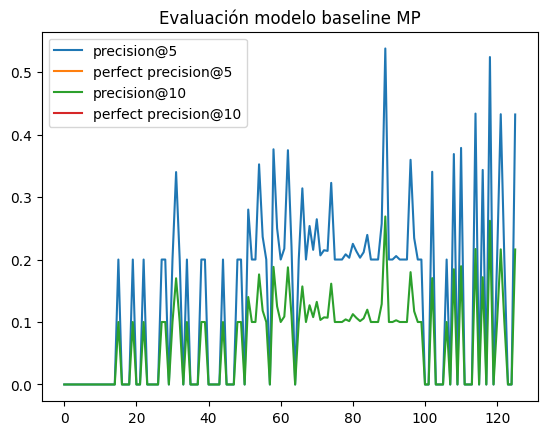

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-05-27 12:00:00,0.497468,0.320609,0.213590,0.106795,0.071197,0.010679,0.497468,0.533587,0.552724,...,0.600000,0.402299,0.565650,0.580896,0.580896,0.580896,0.580896,0.116181,NaN,NaN
min,2023-04-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069176,NaN,NaN
25%,2023-05-11 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070024,NaN,NaN
50%,2023-05-27 12:00:00,0.721797,0.336278,0.201767,0.100883,0.067256,0.010088,0.721797,0.767525,0.863208,...,1.000000,0.445804,0.838386,0.911238,0.911238,0.911238,0.911238,0.130198,NaN,NaN
75%,2023-06-12 06:00:00,0.818784,0.611068,0.409991,0.204995,0.136664,0.020500,0.818784,0.919715,0.919715,...,1.000000,0.593986,0.994932,0.996622,0.996622,0.996622,0.996622,0.154314,NaN,NaN
max,2023-06-28 00:00:00,1.000000,0.712644,0.524138,0.262069,0.174713,0.026207,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.158622,NaN,NaN
std,NaN,0.436943,0.300583,0.208653,0.104326,0.069551,0.010433,0.436943,0.465599,0.477657,...,0.516398,0.397130,0.492329,0.501474,0.501474,0.501474,0.501474,0.041411,NaN,NaN
